In [2]:
from datasets import load_from_disk
processed_dataset = load_from_disk("processed_data")

In [4]:
from torch.utils.data import DataLoader
import torch
import os

def collate_fn(batch):
    images = torch.stack([
        torch.stack([
            torch.tensor(row, dtype=torch.float32) for row in item["image"]
        ], dim=1).permute(2, 0, 1)
        for item in batch
    ])

    labels = torch.tensor([item["label"] for item in batch], dtype=torch.long)

    return {"image": images, "label": labels}

base_path = "./data"

train_dataset = torch.load(os.path.join(base_path, "train.pt"))
val_dataset = torch.load(os.path.join(base_path, "val.pt"))
test_dataset = torch.load(os.path.join(base_path, "test.pt"))

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=4,
    pin_memory=True,
    prefetch_factor=2,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=4,
    pin_memory=True,
    prefetch_factor=2,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=4,
    pin_memory=True,
    prefetch_factor=2,
)

In [5]:
import torch
import torch.nn as nn
from torchvision.models import resnet50
import torch.optim
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet50(pretrained=True)

model.conv1 = nn.Conv2d(
    in_channels=3,
    out_channels=64,
    kernel_size=(7, 7),
    stride=(2, 2),
    padding=(3, 3),
    bias=False
)

num_styles = len(set(processed_dataset["label"]))
model.fc = nn.Linear(
    in_features=model.fc.in_features,
    out_features=num_styles
)
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

best_val_accuracy = 0.0
best_model_state = None

for epoch in range(10):
    print(f"Epoch {epoch + 1}:")
    start = time.time()
    model.train()
    train_loss = 0.0
    train_correct = 0
    total_train = 0

    for batch in train_loader:
        images = batch["image"].clone().permute(0, 3, 1, 2).to(device)
        labels = batch["label"].clone().detach().to(device)

        outputs = model(images)

        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * labels.size(0)
        _, preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        total_train += labels.size(0)

    train_loss /= total_train
    train_accuracy = 100 * train_correct / total_train
    torch.save(model.state_dict(), f"artclass_resnet_{epoch + 1}.pth")
    print(f"Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, Elapsed time: {(time.time() - start)/60} minutes")

    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for batch in val_loader:
            images = batch["image"].clone().permute(0, 3, 1, 2).to(device)
            labels = batch["label"].clone().detach().to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * labels.size(0)
            _, preds = outputs.max(1)
            val_correct += preds.eq(labels).sum().item()
            total_val += labels.size(0)

    val_loss /= total_val
    val_accuracy = 100 * val_correct / total_val
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Elapsed time: {(time.time() - start)/60:.2f} minutes")
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_state = model.state_dict()
        torch.save(best_model_state, "best_resnet.pth")
    torch.cuda.empty_cache()
model.load_state_dict(torch.load("best_resnet.pth"))

Epoch 1:
Training Loss: 2.6605, Accuracy: 20.22%, Elapsed time: 7.120022261142731 minutes
Validation Loss: 2.5113, Validation Accuracy: 24.15%, Elapsed time: 7.78 minutes
Epoch 2:
Training Loss: 2.4504, Accuracy: 25.90%, Elapsed time: 7.111049942175547 minutes
Validation Loss: 2.3957, Validation Accuracy: 25.85%, Elapsed time: 7.77 minutes
Epoch 3:
Training Loss: 2.3625, Accuracy: 27.79%, Elapsed time: 7.109216626485189 minutes
Validation Loss: 2.3382, Validation Accuracy: 27.35%, Elapsed time: 7.77 minutes
Epoch 4:
Training Loss: 2.3087, Accuracy: 28.82%, Elapsed time: 7.111819533507029 minutes
Validation Loss: 2.3130, Validation Accuracy: 27.55%, Elapsed time: 7.77 minutes
Epoch 5:
Training Loss: 2.2739, Accuracy: 29.71%, Elapsed time: 7.10986278851827 minutes
Validation Loss: 2.2748, Validation Accuracy: 30.05%, Elapsed time: 7.76 minutes
Epoch 6:
Training Loss: 2.2423, Accuracy: 30.23%, Elapsed time: 7.110246582825979 minutes
Validation Loss: 2.2589, Validation Accuracy: 30.15%, El

<All keys matched successfully>

Run the following cells to generate confusion matrix and classification report if kernel was restarted.

In [3]:
# import torch
# import torch.nn as nn
# from torchvision.models import resnet50
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = resnet50(pretrained=True)

# model.conv1 = nn.Conv2d(
#     in_channels=3,
#     out_channels=64,
#     kernel_size=(7, 7),
#     stride=(2, 2),
#     padding=(3, 3),
#     bias=False
# )

# num_styles = len(set(processed_dataset["label"]))
# model.fc = nn.Linear(
#     in_features=model.fc.in_features,
#     out_features=num_styles
# )
# for param in model.parameters():
#     param.requires_grad = False

# for param in model.fc.parameters():
#     param.requires_grad = True

# model = model.to(device)
# model.load_state_dict(torch.load("best_resnet.pth"))

<All keys matched successfully>

In [5]:
# from torch.utils.data import DataLoader

# def collate_fn(batch):
#     images = torch.stack([
#         torch.stack([
#             torch.tensor(row, dtype=torch.float32) for row in item["image"]
#         ], dim=1).permute(2, 0, 1)
#         for item in batch
#     ])

#     labels = torch.tensor([item["label"] for item in batch], dtype=torch.long)

#     return {"image": images, "label": labels}

# test_dataset = torch.load("./data/test.pt")

# test_loader = DataLoader(
#     test_dataset, 
#     batch_size=32, 
#     shuffle=True, 
#     collate_fn=collate_fn, 
#     num_workers=4,
#     pin_memory=True, prefetch_factor=2
# )

Test Accuracy: 31.90%


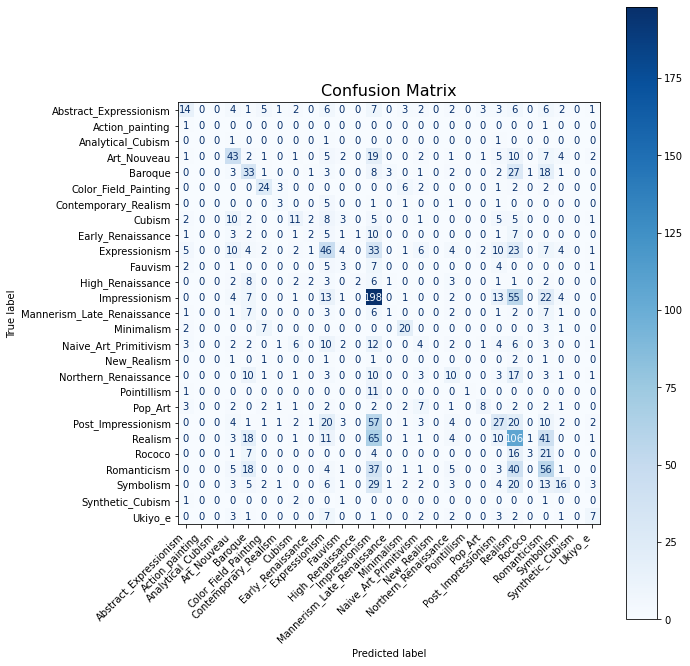

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy
import json

true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch in test_loader:
        images = batch["image"].clone().permute(0, 3, 1, 2).to(device)
        labels = batch["label"].clone().detach().to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())
        
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

with open("num_to_style.json", "r") as f:
    num_to_style = json.load(f)

cm = confusion_matrix(true_labels, predicted_labels)

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[num_to_style[str(i)] for i in range(len(num_to_style))])
disp.plot(cmap=plt.cm.Blues, ax=ax)

plt.title("Confusion Matrix", fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [7]:
from sklearn.metrics import classification_report

class_names = [num_to_style[str(i)] for i in range(len(num_to_style))]

report = classification_report(
    true_labels, 
    predicted_labels, 
    target_names=class_names, 
    digits=4
)
print(report)

                            precision    recall  f1-score   support

    Abstract_Expressionism     0.3784    0.2059    0.2667        68
           Action_painting     0.0000    0.0000    0.0000         2
         Analytical_Cubism     0.0000    0.0000    0.0000         3
               Art_Nouveau     0.4057    0.4057    0.4057       106
                   Baroque     0.2578    0.3173    0.2845       104
      Color_Field_Painting     0.5106    0.6000    0.5517        40
      Contemporary_Realism     0.2727    0.2500    0.2609        12
                    Cubism     0.3333    0.2000    0.2500        55
         Early_Renaissance     0.2222    0.0588    0.0930        34
             Expressionism     0.2754    0.2788    0.2771       165
                   Fauvism     0.1364    0.1304    0.1333        23
          High_Renaissance     0.6667    0.0606    0.1111        33
             Impressionism     0.3743    0.6168    0.4659       321
Mannerism_Late_Renaissance     0.1667    0.0312

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
